Import Necessary Libraries

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import geopandas as gpd

# ETL (Extract, Transform, Load)

## Load and explore the dataset

### Geothermal Gradients Dataset

In [4]:
gradients = pd.read_excel('data/Anexo 1. GRADIENTES GEOTÉRMICOS APARENTES.xlsx',sheet_name=1)
gradients = gradients.rename(columns={"Longitud": "Lon", "Latitud": "Lat"})
gradients.head()

,UWI,Nombre del Pozo,Profundidad Total \n(ft),Departamento,Cuenca,Lat,Lon,Coordenada\nX,Coordenada \n Y,Elevación GL\n(ft),Elevacion \n(m),Temperatura en superficie \n(°C),BHT\n(°F),BHT\n(°C),Profundidad BHT\n(ft),Profundidad BHT \n(m),Temperatura de formación (°C),Gradiente Geotérmico Aparente (°C/Km),Año de actualizacion del dato
0,ABAN0004,ABANICO-4,3020,Tolima,Valle Superior del Magdalena,4.213002,-74.893581,909770.865223,957357.370043,1030.0,313.9440,26.630280,100.0,37.777778,3020.0,920.4960,40.172876,14.712281,2008.0
1,ABAN0005,ABANICO-5,2928,Tolima,Valle Superior del Magdalena,4.216078,-74.888898,910291.244350,957696.956787,1028.0,313.3344,26.633328,110.0,43.333333,2928.0,892.4544,45.637603,21.294394,2008.0
2,ABAN0006,ABANICO-6,2904,Tolima,Valle Superior del Magdalena,4.214720,-74.891220,910033.263457,957547.084087,1038.0,316.3824,26.618088,113.0,45.000000,2842.0,866.2416,47.220262,23.783404,2008.0
3,ACAE0001,ACAE-1,10578,Putumayo,Caguan-Putumayo,0.606276,-76.564731,723420.331087,558549.884585,903.0,275.2344,26.823828,200.0,93.333333,10573.0,3222.6504,104.671211,24.156323,2008.0
4,ACAE0010,ACAE-10,10757,Putumayo,Caguan-Putumayo,0.305911,-76.914853,684390.184013,525315.148844,297.0,90.5256,27.747372,159.0,70.555556,6268.0,1910.4864,76.658202,25.601245,2008.0


### Moho Depth Dataset

In [5]:
moho_depth = pd.read_csv('data/south-american-moho.txt', delim_whitespace=True, comment="#", header=None, names=["Latitude", "Longitude", "Moho Depth (m)"])
moho_depth = moho_depth.rename(columns={"Longitude": "Lon", "Latitude": "Lat"})
moho_depth.head()

,Lat,Lon,Moho Depth (m)
0,-60.0,270.0,32674.89851
1,-60.0,270.4,26702.16351
2,-60.0,270.8,23617.60412
3,-60.0,271.2,22474.44981
4,-60.0,271.6,22003.43619


### LAB depth dataset

In [6]:
file_path = 'data/LithoRef18.xyz'

# Assuming your dataset is tab-separated (TSV) based on the format you provided.
# If it's a different format, you may need to adjust the delimiter or separator.
lab_depth = pd.read_table(file_path, delim_whitespace=True, header=None, names=[
    'LONG', 'LAT', 'ELEVATION', 'MOHO', 'LAB', 'RHO_C', 'RHO_L', 'RHO_SL',
    'BOTTOM', 'GEOID', 'FA', 'G_zz', 'G_xx', 'G_yy'
], skiprows=9)
lab_depth = lab_depth.rename(columns={"LONG": "Lon", "LAT": "Lat"})

lab_depth


,Lon,Lat,ELEVATION,MOHO,LAB,RHO_C,RHO_L,RHO_SL,BOTTOM,GEOID,FA,G_zz,G_xx,G_yy
0,-179.0,-89.0,2965.0,-38880.18,-120036.38,2850.92,3329.86,3437.13,-410000.0,-0.81,0.82,0.01,0.04,-0.12
1,-179.0,-87.0,2915.0,-38880.18,-120036.38,2850.92,3329.86,3437.13,-410000.0,5.01,38.25,0.33,-0.10,-0.23
2,-179.0,-85.0,1680.0,-40068.56,-61717.27,2754.42,3274.83,3445.69,-410000.0,4.78,36.06,0.22,-0.10,-0.12
3,-179.0,-83.0,17.5,-27384.31,-49505.28,2789.22,3270.61,3431.93,-410000.0,0.15,-17.35,-0.08,-0.02,0.10
4,-179.0,-81.0,-2.5,-28174.61,-34705.37,2755.78,3247.06,3429.78,-410000.0,0.81,-0.02,-0.06,-0.00,0.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16195,179.0,81.0,-1960.0,-16517.33,-97953.06,2686.46,3322.25,3442.41,-410000.0,2.76,8.78,-0.00,-0.10,0.09
16196,179.0,83.0,-2467.5,-19075.27,-108049.57,2783.24,3335.58,3444.81,-410000.0,3.28,6.77,0.07,-0.12,0.05
16197,179.0,85.0,-2422.5,-17274.34,-121981.55,2740.28,3348.45,3443.39,-410000.0,3.42,13.84,0.12,-0.10,-0.02
16198,179.0,87.0,-3822.5,-14569.69,-124492.00,2806.42,3350.09,3443.20,-410000.0,1.52,3.85,0.04,-0.06,0.02


### Volcanos

In [7]:
volcanos = pd.read_csv('data/Volcanes_col.csv')
volcanos = volcanos.rename(columns={"X": "Lon", "Y": "Lat"})
volcanos.head()

,Lon,Lat,OBJECTID,VolcanID,NombreVolcan,AlturaSobreNivelMar,Latitud,Longitud,Comentarios,URL,GlobalID
0,-76.214977,1.916518,1,NaN,NaN,1800.0,"1° 54' 59,465"" N","76° 12' 53,917"" W",Edificio volcánico en el municipio de Isnos en...,NaN,071b82b6-5b8a-47d0-ba87-5ebfd34e4bac
1,-76.166495,2.232286,2,NaN,Volcan Santa Leticia,NaN,"2° 13' 56,229"" N","76° 9' 59,382"" W",NaN,NaN,f5a4cc3d-fc7e-46a1-b8d9-69fdcb4a541a
2,-76.082576,2.179546,3,NaN,Volcán El Pensil,2200.0,"2° 10' 46,366"" N","76° 4' 57,273"" W",NaN,NaN,e09ff266-bee3-4ea4-98df-8765b2c0b164
3,-76.217778,2.110280,4,NaN,Volcán El Dorado,2000.0,"2° 6' 37,008"" N","76° 13' 4,001"" W",NaN,NaN,073bdc7f-d632-4954-a383-cc1d4d083b7c
4,-76.477694,2.240949,5,NaN,Maar de Yerbabuena,3100.0,"2° 14' 27,415"" N","76° 28' 39,697"" W",NaN,NaN,d6077acc-cac2-4c9b-be59-64ba98040e8a


## Data Preprocessing

### Moho Depth

We need to convert the Longitude from 0, 360° to -180°, 180°

In [8]:
moho_depth["Lon"] = moho_depth["Lon"].apply(lambda x: x - 360 if x > 180 else x)

moho_depth.head()

,Lat,Lon,Moho Depth (m)
0,-60.0,-90.0,32674.89851
1,-60.0,-89.6,26702.16351
2,-60.0,-89.2,23617.60412
3,-60.0,-88.8,22474.44981
4,-60.0,-88.4,22003.43619


Crop the moho_depth dataset so that it fits within the spatial extent of the first dataset (geothermal gradient).

In [9]:
# Define the spatial extent boundaries from the "gradients" dataset
min_lat = gradients["Lat"].min()
max_lat = gradients["Lat"].max()
min_lon = gradients["Lon"].min()
max_lon = gradients["Lon"].max()

# Crop the "moho_depth" dataset to fit within the spatial extent of the "gradients" dataset
moho_depth= moho_depth[
    (moho_depth["Lat"] >= min_lat) & (moho_depth["Lat"] <= max_lat) &
    (moho_depth["Lon"] >= min_lon) & (moho_depth["Lon"] <= max_lon)
]

moho_depth.head()

,Lat,Lon,Moho Depth (m)
22830,0.4,-78.4,45833.63750
22831,0.4,-78.0,50558.10643
22832,0.4,-77.6,50195.81961
22833,0.4,-77.2,43388.77930
22834,0.4,-76.8,37111.13688


In [10]:
missing_values = moho_depth.isnull().sum()
missing_values

Lat               0
Lon               0
Moho Depth (m)    0
dtype: int64

### LAB depth

In [11]:
min_lat = gradients["Lat"].min()
max_lat = gradients["Lat"].max()
min_lon = gradients["Lon"].min()
max_lon = gradients["Lon"].max()

# Crop the "lab_depth" dataset to fit within the spatial extent of the "gradients" dataset
lab_depth= lab_depth[
    (lab_depth["Lat"] >= min_lat) & (lab_depth["Lat"] <= max_lat) &
    (lab_depth["Lon"] >= min_lon) & (lab_depth["Lon"] <= max_lon)
]

lab_depth.head()

,Lon,Lat,ELEVATION,MOHO,LAB,RHO_C,RHO_L,RHO_SL,BOTTOM,GEOID,FA,G_zz,G_xx,G_yy
4635,-77.0,1.0,1495.0,-40647.17,-63446.49,2829.05,3277.31,3440.64,-410000.0,7.96,51.41,0.77,-0.45,-0.31
4636,-77.0,3.0,1072.5,-32645.03,-112978.59,2825.48,3326.39,3446.82,-410000.0,9.19,60.12,0.74,-0.48,-0.25
4637,-77.0,5.0,-110.0,-23652.27,-122638.24,2812.60,3337.53,3443.48,-410000.0,6.25,7.18,0.49,-0.29,-0.21
4638,-77.0,7.0,135.0,-25305.50,-159309.84,2800.00,3351.29,3454.54,-410000.0,8.29,48.67,0.63,-0.25,-0.38
4639,-77.0,9.0,-627.5,-23946.71,-148313.22,2772.06,3353.93,3454.02,-410000.0,0.53,-10.40,0.10,-0.08,-0.02


In [12]:
lab_depth.columns

Index(['Lon', 'Lat', 'ELEVATION', 'MOHO', 'LAB', 'RHO_C', 'RHO_L', 'RHO_SL',
       'BOTTOM', 'GEOID', 'FA', 'G_zz', 'G_xx', 'G_yy'],
      dtype='object')

### Gradients

In [13]:
# Check for missing values
missing_values = gradients.isnull().sum()
missing_values

UWI                                       32
Nombre del Pozo                           30
Profundidad Total \n(ft)                  33
Departamento                              38
Cuenca                                    38
Lat                                      100
Lon                                      100
Coordenada\nX                             38
Coordenada \n Y                           38
Elevación GL\n(ft)                       444
Elevacion \n(m)                           38
Temperatura en superficie \n(°C)          38
BHT\n(°F)                                 38
BHT\n(°C)                                 38
Profundidad BHT\n(ft)                     38
Profundidad BHT \n(m)                     38
Temperatura de formación (°C)             38
Gradiente Geotérmico Aparente (°C/Km)     38
Año de actualizacion del dato             38
dtype: int64

Remove rows without geothermal gradient, latitude or longitude values

In [14]:
gradients = gradients.dropna(subset=["Gradiente Geotérmico Aparente (°C/Km)"])
gradients = gradients.dropna(subset=["Lat", "Lon"])

gradients.tail()

,UWI,Nombre del Pozo,Profundidad Total \n(ft),Departamento,Cuenca,Lat,Lon,Coordenada\nX,Coordenada \n Y,Elevación GL\n(ft),Elevacion \n(m),Temperatura en superficie \n(°C),BHT\n(°F),BHT\n(°C),Profundidad BHT\n(ft),Profundidad BHT \n(m),Temperatura de formación (°C),Gradiente Geotérmico Aparente (°C/Km),Año de actualizacion del dato
4600,ZENO0001,ZENON-1,6422,Bolivar,Valle Inferior del Magdalena,9.198753,-74.545831,9.489047e+05,1.508724e+06,49.0,14.9352,28.125324,152.0,66.666667,6423.0,1957.7304,72.962956,22.902864,2008.0
4601,ZENO0002,ZENON-2,6196,Bolivar,Valle Inferior del Magdalena,9.193783,-74.545203,9.489730e+05,1.508175e+06,58.0,17.6784,28.111608,152.0,66.666667,6196.0,1888.5408,72.679641,23.599190,2008.0
4602,ZENO0003,ZENON-3,6559,Magdalena,Valle Inferior del Magdalena,9.210378,-74.266786,9.795733e+05,1.509982e+06,70.0,21.3360,28.093320,152.0,66.666667,6559.0,1999.1832,73.133462,22.529272,2008.0
4603,ZULI0001W,ZULIA WEST-1,7655,Norte de Santander,Catatumbo,8.213381,-72.470731,1.177448e+06,1.400064e+06,285.0,86.8680,27.765660,166.0,74.444444,7765.0,2366.7720,82.434751,23.098588,2008.0
4604,ZULI0001E,ZULIA-1 EAST,3361.5,Norte de Santander,Catatumbo,8.202650,-72.439292,1.180919e+06,1.398891e+06,NaN,114.0000,27.630000,112.0,44.444444,3410.0,1039.3680,47.235248,18.862662,2008.0


In [15]:
missing_values = gradients.isnull().sum()
missing_values

UWI                                        0
Nombre del Pozo                            0
Profundidad Total \n(ft)                   0
Departamento                               0
Cuenca                                     0
Lat                                        0
Lon                                        0
Coordenada\nX                              0
Coordenada \n Y                            0
Elevación GL\n(ft)                       348
Elevacion \n(m)                            0
Temperatura en superficie \n(°C)           0
BHT\n(°F)                                  0
BHT\n(°C)                                  0
Profundidad BHT\n(ft)                      0
Profundidad BHT \n(m)                      0
Temperatura de formación (°C)              0
Gradiente Geotérmico Aparente (°C/Km)      0
Año de actualizacion del dato              0
dtype: int64

In [16]:
for col in gradients.columns:
    print(col)

UWI
Nombre del Pozo
Profundidad Total 
(ft)
Departamento
Cuenca
Lat
Lon
Coordenada
X
Coordenada 
 Y
Elevación GL
(ft)
Elevacion 
(m)
Temperatura en superficie 
(°C)
BHT
(°F)
BHT
(°C)
Profundidad BHT
(ft)
Profundidad BHT 
(m)
Temperatura de formación (°C)
Gradiente Geotérmico Aparente (°C/Km)
Año de actualizacion del dato


### Volcanos

In [17]:
missing_values = volcanos.isnull().sum()
missing_values

Lon                     0
Lat                     0
OBJECTID                0
VolcanID               61
NombreVolcan           14
AlturaSobreNivelMar     4
Latitud                 0
Longitud                0
Comentarios            54
URL                    41
GlobalID                0
dtype: int64

There's not much to do with volcanos dataset as they don't have missing Lon and Lat values.

## Feature Engineering

### Distance to nearest volcano

In [18]:
import geopandas as gpd
from shapely.geometry import Point
import math

In [19]:
# Load the "gradients" and "volcanos" datasets into GeoDataFrames
gradients_gdf = gpd.GeoDataFrame(gradients, geometry=gpd.points_from_xy(gradients['Lon'], gradients['Lat']))
volcanos_gdf = gpd.GeoDataFrame(volcanos, geometry=gpd.points_from_xy(volcanos['Lon'], volcanos['Lat']))

# Initialize an empty list to store distances to the nearest volcano (in meters)
distances_to_nearest_volcano = []

# Radius of the Earth in meters
earth_radius = 6371000  # Approximately

# Iterate through each well
for well in gradients_gdf.itertuples():
    nearest_volcano_distance = float('inf')  # Initialize with a large value
    
    # Iterate through each volcano to find the nearest one
    for volcano in volcanos_gdf.itertuples():
        # Haversine formula to calculate the great-circle distance
        lon1, lat1 = well.geometry.x, well.geometry.y
        lon2, lat2 = volcano.geometry.x, volcano.geometry.y

        dlon = math.radians(lon2 - lon1)
        dlat = math.radians(lat2 - lat1)

        a = math.sin(dlat/2)**2 + math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.sin(dlon/2)**2
        c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

        distance = earth_radius * c
        nearest_volcano_distance = min(nearest_volcano_distance, distance)
    
    distances_to_nearest_volcano.append(nearest_volcano_distance)

# Add the distances to the "gradients" dataset as a new column (in meters)
gradients['Distance_To_Nearest_Volcano (m)'] = distances_to_nearest_volcano

In [20]:
gradients.head()

,UWI,Nombre del Pozo,Profundidad Total \n(ft),Departamento,Cuenca,Lat,Lon,Coordenada\nX,Coordenada \n Y,Elevación GL\n(ft),Elevacion \n(m),Temperatura en superficie \n(°C),BHT\n(°F),BHT\n(°C),Profundidad BHT\n(ft),Profundidad BHT \n(m),Temperatura de formación (°C),Gradiente Geotérmico Aparente (°C/Km),Año de actualizacion del dato,Distance_To_Nearest_Volcano (m)
0,ABAN0004,ABANICO-4,3020,Tolima,Valle Superior del Magdalena,4.213002,-74.893581,909770.865223,957357.370043,1030.0,313.9440,26.630280,100.0,37.777778,3020.0,920.4960,40.172876,14.712281,2008.0,37601.741109
1,ABAN0005,ABANICO-5,2928,Tolima,Valle Superior del Magdalena,4.216078,-74.888898,910291.244350,957696.956787,1028.0,313.3344,26.633328,110.0,43.333333,2928.0,892.4544,45.637603,21.294394,2008.0,37852.172379
2,ABAN0006,ABANICO-6,2904,Tolima,Valle Superior del Magdalena,4.214720,-74.891220,910033.263457,957547.084087,1038.0,316.3824,26.618088,113.0,45.000000,2842.0,866.2416,47.220262,23.783404,2008.0,37716.838356
3,ACAE0001,ACAE-1,10578,Putumayo,Caguan-Putumayo,0.606276,-76.564731,723420.331087,558549.884585,903.0,275.2344,26.823828,200.0,93.333333,10573.0,3222.6504,104.671211,24.156323,2008.0,74806.593793
4,ACAE0010,ACAE-10,10757,Putumayo,Caguan-Putumayo,0.305911,-76.914853,684390.184013,525315.148844,297.0,90.5256,27.747372,159.0,70.555556,6268.0,1910.4864,76.658202,25.601245,2008.0,84902.242439


### Volcanos nearby (within radius = nearest volcano + 5 Km)

In [21]:
import geopy.distance

# The radius is the distance to the nearest volcano plus 5000 meters (5 kilometers)
gradients['Radius (m)'] = gradients['Distance_To_Nearest_Volcano (m)'] + 5000

# Initialize an empty list to store the counts of nearby volcanoes
num_volcanoes_nearby = []

# Iterate through each well to count nearby volcanoes
for index, row in gradients.iterrows():
    well_location = (row['Lat'], row['Lon'])
    radius = row['Radius (m)']
    
    # Calculate the number of volcanoes within the specified radius
    num_nearby_volcanoes = len(volcanos[
        volcanos.apply(lambda x: geopy.distance.distance(well_location, (x['Lat'], x['Lon'])).m <= radius, axis=1)
    ])
    
    num_volcanoes_nearby.append(num_nearby_volcanoes)

# Add the "Number of Volcanoes Nearby" feature to the "gradients" dataset
gradients['Number of Volcanoes Nearby'] = num_volcanoes_nearby

# Verify the updated dataset
gradients.head()

,UWI,Nombre del Pozo,Profundidad Total \n(ft),Departamento,Cuenca,Lat,Lon,Coordenada\nX,Coordenada \n Y,Elevación GL\n(ft),...,BHT\n(°F),BHT\n(°C),Profundidad BHT\n(ft),Profundidad BHT \n(m),Temperatura de formación (°C),Gradiente Geotérmico Aparente (°C/Km),Año de actualizacion del dato,Distance_To_Nearest_Volcano (m),Radius (m),Number of Volcanoes Nearby
0,ABAN0004,ABANICO-4,3020,Tolima,Valle Superior del Magdalena,4.213002,-74.893581,909770.865223,957357.370043,1030.0,...,100.0,37.777778,3020.0,920.4960,40.172876,14.712281,2008.0,37601.741109,42601.741109,2
1,ABAN0005,ABANICO-5,2928,Tolima,Valle Superior del Magdalena,4.216078,-74.888898,910291.244350,957696.956787,1028.0,...,110.0,43.333333,2928.0,892.4544,45.637603,21.294394,2008.0,37852.172379,42852.172379,2
2,ABAN0006,ABANICO-6,2904,Tolima,Valle Superior del Magdalena,4.214720,-74.891220,910033.263457,957547.084087,1038.0,...,113.0,45.000000,2842.0,866.2416,47.220262,23.783404,2008.0,37716.838356,42716.838356,2
3,ACAE0001,ACAE-1,10578,Putumayo,Caguan-Putumayo,0.606276,-76.564731,723420.331087,558549.884585,903.0,...,200.0,93.333333,10573.0,3222.6504,104.671211,24.156323,2008.0,74806.593793,79806.593793,5
4,ACAE0010,ACAE-10,10757,Putumayo,Caguan-Putumayo,0.305911,-76.914853,684390.184013,525315.148844,297.0,...,159.0,70.555556,6268.0,1910.4864,76.658202,25.601245,2008.0,84902.242439,89902.242439,5


### Moho Depth

In [22]:
# Load the "gradients" and "moho_depth" datasets into GeoDataFrames
gradients_gdf = gpd.GeoDataFrame(gradients, geometry=gpd.points_from_xy(gradients['Lon'], gradients['Lat']))
moho_depth_gdf = gpd.GeoDataFrame(moho_depth, geometry=gpd.points_from_xy(moho_depth['Lon'], moho_depth['Lat']))

# Initialize an empty list to store Moho depth values for each well
moho_depth_values = []

# Iterate through each well
for well in gradients_gdf.itertuples():
    nearest_moho_depth = None
    
    # Iterate through each Moho depth location to find the nearest one
    for moho_location in moho_depth_gdf.itertuples():
        distance = well.geometry.distance(moho_location.geometry)
        
        if nearest_moho_depth is None or distance < nearest_moho_depth[0]:
            nearest_moho_depth = (distance, moho_location._3)  # Access the Moho depth attribute using dot notation
    
    # Append the Moho depth value to the list
    moho_depth_values.append(nearest_moho_depth[1] if nearest_moho_depth else None)

# Add the Moho depth values to the "gradients" dataset as a new column
gradients['Moho_Depth (m)'] = moho_depth_values

In [23]:
gradients.head()

,UWI,Nombre del Pozo,Profundidad Total \n(ft),Departamento,Cuenca,Lat,Lon,Coordenada\nX,Coordenada \n Y,Elevación GL\n(ft),...,BHT\n(°C),Profundidad BHT\n(ft),Profundidad BHT \n(m),Temperatura de formación (°C),Gradiente Geotérmico Aparente (°C/Km),Año de actualizacion del dato,Distance_To_Nearest_Volcano (m),Radius (m),Number of Volcanoes Nearby,Moho_Depth (m)
0,ABAN0004,ABANICO-4,3020,Tolima,Valle Superior del Magdalena,4.213002,-74.893581,909770.865223,957357.370043,1030.0,...,37.777778,3020.0,920.4960,40.172876,14.712281,2008.0,37601.741109,42601.741109,2,42722.81991
1,ABAN0005,ABANICO-5,2928,Tolima,Valle Superior del Magdalena,4.216078,-74.888898,910291.244350,957696.956787,1028.0,...,43.333333,2928.0,892.4544,45.637603,21.294394,2008.0,37852.172379,42852.172379,2,42722.81991
2,ABAN0006,ABANICO-6,2904,Tolima,Valle Superior del Magdalena,4.214720,-74.891220,910033.263457,957547.084087,1038.0,...,45.000000,2842.0,866.2416,47.220262,23.783404,2008.0,37716.838356,42716.838356,2,42722.81991
3,ACAE0001,ACAE-1,10578,Putumayo,Caguan-Putumayo,0.606276,-76.564731,723420.331087,558549.884585,903.0,...,93.333333,10573.0,3222.6504,104.671211,24.156323,2008.0,74806.593793,79806.593793,5,36748.55113
4,ACAE0010,ACAE-10,10757,Putumayo,Caguan-Putumayo,0.305911,-76.914853,684390.184013,525315.148844,297.0,...,70.555556,6268.0,1910.4864,76.658202,25.601245,2008.0,84902.242439,89902.242439,5,37111.13688


### LAB Depth

In [24]:
# Create GeoDataFrames from datasets
gradients_gdf = gpd.GeoDataFrame(gradients, geometry=gpd.points_from_xy(gradients['Lon'], gradients['Lat']))
lab_depth_gdf = gpd.GeoDataFrame(lab_depth, geometry=gpd.points_from_xy(lab_depth['Lon'], lab_depth['Lat']))

# Initialize empty list to store lab depth values
lab_depth_values = []

for well in gradients_gdf.itertuples():
    nearest_lab_depth = None
    
    for lab_location in lab_depth_gdf.itertuples():
        distance = well.geometry.distance(lab_location.geometry)
        
        if nearest_lab_depth is None or distance < nearest_lab_depth[0]:
            nearest_lab_depth = (distance, lab_location.LAB)  # Use 'LAB' as the column name
    
    lab_depth_values.append(nearest_lab_depth[1] if nearest_lab_depth else None)

# Add the 'LAB' column to the gradients DataFrame
gradients['LAB'] = lab_depth_values

In [25]:
# Define the columns to be added from lab_depth
columns_to_add = ['RHO_C', 'RHO_L', 'RHO_SL', 'FA', 'G_zz', 'G_xx', 'G_yy', 'LAB']

# Perform an inner join on 'LAB' to add the specified columns
gradients_2 = gradients.merge(lab_depth[columns_to_add], left_on='LAB', right_on='LAB', how='inner')

In [26]:
gradients_2.head()

,UWI,Nombre del Pozo,Profundidad Total \n(ft),Departamento,Cuenca,Lat,Lon,Coordenada\nX,Coordenada \n Y,Elevación GL\n(ft),...,Number of Volcanoes Nearby,Moho_Depth (m),LAB,RHO_C,RHO_L,RHO_SL,FA,G_zz,G_xx,G_yy
0,ABAN0004,ABANICO-4,3020,Tolima,Valle Superior del Magdalena,4.213002,-74.893581,909770.865223,9.573574e+05,1030.0,...,2,42722.81991,-190257.15,2868.17,3348.9,3474.22,53.51,1.03,-0.58,-0.45
1,ABAN0005,ABANICO-5,2928,Tolima,Valle Superior del Magdalena,4.216078,-74.888898,910291.244350,9.576970e+05,1028.0,...,2,42722.81991,-190257.15,2868.17,3348.9,3474.22,53.51,1.03,-0.58,-0.45
2,ABAN0006,ABANICO-6,2904,Tolima,Valle Superior del Magdalena,4.214720,-74.891220,910033.263457,9.575471e+05,1038.0,...,2,42722.81991,-190257.15,2868.17,3348.9,3474.22,53.51,1.03,-0.58,-0.45
3,AGAT0001,AGATA-1,6201,Boyacá,Valle Medio del Magdalena,5.830164,-74.321856,973547.350579,1.136101e+06,940.0,...,1,38981.06791,-190257.15,2868.17,3348.9,3474.22,53.51,1.03,-0.58,-0.45
4,ALCO0001,ALCON-1,2195,Cundinamarca,Valle Medio del Magdalena,5.092486,-74.585899,944003.116785,1.054588e+06,553.0,...,2,44230.77916,-190257.15,2868.17,3348.9,3474.22,53.51,1.03,-0.58,-0.45


In [27]:
gradients = gradients_2
gradients['LAB'] = gradients['LAB'].abs()

In [28]:
gradients.head()

,UWI,Nombre del Pozo,Profundidad Total \n(ft),Departamento,Cuenca,Lat,Lon,Coordenada\nX,Coordenada \n Y,Elevación GL\n(ft),...,Number of Volcanoes Nearby,Moho_Depth (m),LAB,RHO_C,RHO_L,RHO_SL,FA,G_zz,G_xx,G_yy
0,ABAN0004,ABANICO-4,3020,Tolima,Valle Superior del Magdalena,4.213002,-74.893581,909770.865223,9.573574e+05,1030.0,...,2,42722.81991,190257.15,2868.17,3348.9,3474.22,53.51,1.03,-0.58,-0.45
1,ABAN0005,ABANICO-5,2928,Tolima,Valle Superior del Magdalena,4.216078,-74.888898,910291.244350,9.576970e+05,1028.0,...,2,42722.81991,190257.15,2868.17,3348.9,3474.22,53.51,1.03,-0.58,-0.45
2,ABAN0006,ABANICO-6,2904,Tolima,Valle Superior del Magdalena,4.214720,-74.891220,910033.263457,9.575471e+05,1038.0,...,2,42722.81991,190257.15,2868.17,3348.9,3474.22,53.51,1.03,-0.58,-0.45
3,AGAT0001,AGATA-1,6201,Boyacá,Valle Medio del Magdalena,5.830164,-74.321856,973547.350579,1.136101e+06,940.0,...,1,38981.06791,190257.15,2868.17,3348.9,3474.22,53.51,1.03,-0.58,-0.45
4,ALCO0001,ALCON-1,2195,Cundinamarca,Valle Medio del Magdalena,5.092486,-74.585899,944003.116785,1.054588e+06,553.0,...,2,44230.77916,190257.15,2868.17,3348.9,3474.22,53.51,1.03,-0.58,-0.45


## Dataset cleaning

In [29]:
# Replace "\n" with a space in column names
gradients.columns = gradients.columns.str.replace('\n', ' ')

In [30]:
gradients.columns = gradients.columns.str.replace('  ', ' ')
gradients.columns = gradients.columns.str.replace('   ', ' ')

In [31]:
gradients.head()

,UWI,Nombre del Pozo,Profundidad Total (ft),Departamento,Cuenca,Lat,Lon,Coordenada X,Coordenada Y,Elevación GL (ft),...,Number of Volcanoes Nearby,Moho_Depth (m),LAB,RHO_C,RHO_L,RHO_SL,FA,G_zz,G_xx,G_yy
0,ABAN0004,ABANICO-4,3020,Tolima,Valle Superior del Magdalena,4.213002,-74.893581,909770.865223,9.573574e+05,1030.0,...,2,42722.81991,190257.15,2868.17,3348.9,3474.22,53.51,1.03,-0.58,-0.45
1,ABAN0005,ABANICO-5,2928,Tolima,Valle Superior del Magdalena,4.216078,-74.888898,910291.244350,9.576970e+05,1028.0,...,2,42722.81991,190257.15,2868.17,3348.9,3474.22,53.51,1.03,-0.58,-0.45
2,ABAN0006,ABANICO-6,2904,Tolima,Valle Superior del Magdalena,4.214720,-74.891220,910033.263457,9.575471e+05,1038.0,...,2,42722.81991,190257.15,2868.17,3348.9,3474.22,53.51,1.03,-0.58,-0.45
3,AGAT0001,AGATA-1,6201,Boyacá,Valle Medio del Magdalena,5.830164,-74.321856,973547.350579,1.136101e+06,940.0,...,1,38981.06791,190257.15,2868.17,3348.9,3474.22,53.51,1.03,-0.58,-0.45
4,ALCO0001,ALCON-1,2195,Cundinamarca,Valle Medio del Magdalena,5.092486,-74.585899,944003.116785,1.054588e+06,553.0,...,2,44230.77916,190257.15,2868.17,3348.9,3474.22,53.51,1.03,-0.58,-0.45


In [32]:
# Convert "Profundidad BHT (ft)" to meters (1 ft = 0.3048 m)
gradients['Profundidad BHT (m)'] = gradients['Profundidad BHT (ft)'] * 0.3048

In [33]:
gradients.columns

Index(['UWI', 'Nombre del Pozo', 'Profundidad Total (ft)', 'Departamento',
       'Cuenca', 'Lat', 'Lon', 'Coordenada X', 'Coordenada  Y',
       'Elevación GL (ft)', 'Elevacion (m)', 'Temperatura en superficie (°C)',
       'BHT (°F)', 'BHT (°C)', 'Profundidad BHT (ft)', 'Profundidad BHT (m)',
       'Temperatura de formación (°C)',
       'Gradiente Geotérmico Aparente (°C/Km)',
       'Año de actualizacion del dato', 'Distance_To_Nearest_Volcano (m)',
       'Radius (m)', 'Number of Volcanoes Nearby', 'Moho_Depth (m)', 'LAB',
       'RHO_C', 'RHO_L', 'RHO_SL', 'FA', 'G_zz', 'G_xx', 'G_yy'],
      dtype='object')

Select and rename columns

In [35]:
columns_to_remove = ['UWI', 'Nombre del Pozo', 'Profundidad Total (ft)', 'Departamento', 'Cuenca', 'Coordenada X', 'Coordenada  Y', 'Elevación GL (ft)', 'BHT (°F)', 'BHT (°C)', 'Profundidad BHT (ft)', 'Profundidad BHT (m)', 'Temperatura de formación (°C)', 'Año de actualizacion del dato', 'Radius (m)']

cleaned_data = gradients.drop(columns=columns_to_remove)

In [36]:
# Create a dictionary to map the Spanish column names to English column names
column_name_mapping = {
    'Lat': 'Latitude',
    'Lon': 'Longitude',
    'Elevacion (m)': 'Elevation (m)',
    'Temperatura en superficie (°C)': 'Surface Temperature (°C)',
    'Gradiente Geotérmico Aparente (°C/Km)': 'Apparent Geothermal Gradient (°C/Km)',
    'Distance_To_Nearest_Volcano (m)': 'Distance To Nearest Volcano (m)',
    'Number of Volcanoes Nearby': 'Number of Volcanoes Nearby',
    'Moho_Depth (m)': 'Moho Depth (m)',
    'LAB': 'LAB',
    'RHO_C': 'Crustal Density (kg/m³)',
    'RHO_L': 'Lithospheric Density (kg/m³)',
    'RHO_SL': 'Sub-Lithospheric Density (kg/m³)',
    'FA': 'Flexural Rigidity (Pa⁻¹)',
    'G_zz': 'Gravitational Acceleration z-component (m/s²)',
    'G_xx': 'Gravitational Acceleration x-component (m/s²)',
    'G_yy': 'Gravitational Acceleration y-component (m/s²)'
}

# Rename the columns using the dictionary
cleaned_data = cleaned_data.rename(columns=column_name_mapping)

In [37]:
cleaned_data.head()

,Latitude,Longitude,Elevation (m),Surface Temperature (°C),Apparent Geothermal Gradient (°C/Km),Distance To Nearest Volcano (m),Number of Volcanoes Nearby,Moho Depth (m),LAB,Crustal Density (kg/m³),Lithospheric Density (kg/m³),Sub-Lithospheric Density (kg/m³),Flexural Rigidity (Pa⁻¹),Gravitational Acceleration z-component (m/s²),Gravitational Acceleration x-component (m/s²),Gravitational Acceleration y-component (m/s²)
0,4.213002,-74.893581,313.9440,26.630280,14.712281,37601.741109,2,42722.81991,190257.15,2868.17,3348.9,3474.22,53.51,1.03,-0.58,-0.45
1,4.216078,-74.888898,313.3344,26.633328,21.294394,37852.172379,2,42722.81991,190257.15,2868.17,3348.9,3474.22,53.51,1.03,-0.58,-0.45
2,4.214720,-74.891220,316.3824,26.618088,23.783404,37716.838356,2,42722.81991,190257.15,2868.17,3348.9,3474.22,53.51,1.03,-0.58,-0.45
3,5.830164,-74.321856,286.5120,26.767440,25.403742,73424.879560,1,38981.06791,190257.15,2868.17,3348.9,3474.22,53.51,1.03,-0.58,-0.45
4,5.092486,-74.585899,168.5544,27.357228,37.921894,69402.762555,2,44230.77916,190257.15,2868.17,3348.9,3474.22,53.51,1.03,-0.58,-0.45


In [38]:
# Save the DataFrame to a new CSV file
cleaned_data.to_csv('cleaned_data.csv', index=False)

In [123]:
cleaned_data = pd.read_csv('cleaned_data.csv')
cleaned_data.head()

,Latitude,Longitude,Elevation (m),Surface Temperature (°C),Apparent Geothermal Gradient (°C/Km),Distance To Nearest Volcano (m),Number of Volcanoes Nearby,Moho Depth (m),LAB,Crustal Density (kg/m³),Lithospheric Density (kg/m³),Sub-Lithospheric Density (kg/m³),Flexural Rigidity (Pa⁻¹),Gravitational Acceleration z-component (m/s²),Gravitational Acceleration x-component (m/s²),Gravitational Acceleration y-component (m/s²)
0,4.213002,-74.893581,313.9440,26.630280,14.712281,37601.741109,2,42722.81991,190257.15,2868.17,3348.9,3474.22,53.51,1.03,-0.58,-0.45
1,4.216078,-74.888898,313.3344,26.633328,21.294394,37852.172379,2,42722.81991,190257.15,2868.17,3348.9,3474.22,53.51,1.03,-0.58,-0.45
2,4.214720,-74.891220,316.3824,26.618088,23.783404,37716.838356,2,42722.81991,190257.15,2868.17,3348.9,3474.22,53.51,1.03,-0.58,-0.45
3,5.830164,-74.321856,286.5120,26.767440,25.403742,73424.879560,1,38981.06791,190257.15,2868.17,3348.9,3474.22,53.51,1.03,-0.58,-0.45
4,5.092486,-74.585899,168.5544,27.357228,37.921894,69402.762555,2,44230.77916,190257.15,2868.17,3348.9,3474.22,53.51,1.03,-0.58,-0.45


### Normalization of the data

Input data needs to be normalized as the features are in different scales. Target (heat flow) is not being normalized.

In [124]:
cleaned_data.columns

Index(['Latitude', 'Longitude', 'Elevation (m)', 'Surface Temperature (°C)',
       'Apparent Geothermal Gradient (°C/Km)',
       'Distance To Nearest Volcano (m)', 'Number of Volcanoes Nearby',
       'Moho Depth (m)', 'LAB', 'Crustal Density (kg/m³)',
       'Lithospheric Density (kg/m³)', 'Sub-Lithospheric Density (kg/m³)',
       'Flexural Rigidity (Pa⁻¹)',
       'Gravitational Acceleration z-component (m/s²)',
       'Gravitational Acceleration x-component (m/s²)',
       'Gravitational Acceleration y-component (m/s²)'],
      dtype='object')

In [125]:
from sklearn.preprocessing import MinMaxScaler

columns_to_normalize = ['Elevation (m)', 'Surface Temperature (°C)',
                        'Distance To Nearest Volcano (m)', 'Number of Volcanoes Nearby',
                        'Moho Depth (m)', 'LAB', 'Crustal Density (kg/m³)',
                        'Lithospheric Density (kg/m³)', 'Sub-Lithospheric Density (kg/m³)',
                        'Flexural Rigidity (Pa⁻¹)',]

# Initialize the Min-Max scaler
scaler = MinMaxScaler()

# Fit and transform the selected columns
cleaned_data[columns_to_normalize] = scaler.fit_transform(cleaned_data[columns_to_normalize])

# Save the normalized data to a new CSV file
cleaned_data.to_csv('normalized_data_minmax.csv', index=False)

In [126]:
cleaned_data.head()

,Latitude,Longitude,Elevation (m),Surface Temperature (°C),Apparent Geothermal Gradient (°C/Km),Distance To Nearest Volcano (m),Number of Volcanoes Nearby,Moho Depth (m),LAB,Crustal Density (kg/m³),Lithospheric Density (kg/m³),Sub-Lithospheric Density (kg/m³),Flexural Rigidity (Pa⁻¹),Gravitational Acceleration z-component (m/s²),Gravitational Acceleration x-component (m/s²),Gravitational Acceleration y-component (m/s²)
0,4.213002,-74.893581,0.100752,0.899248,14.712281,0.034231,0.142857,0.708538,1.0,0.717651,0.886783,0.780749,0.84464,1.03,-0.58,-0.45
1,4.216078,-74.888898,0.100557,0.899443,21.294394,0.034546,0.142857,0.708538,1.0,0.717651,0.886783,0.780749,0.84464,1.03,-0.58,-0.45
2,4.214720,-74.891220,0.101535,0.898465,23.783404,0.034375,0.142857,0.708538,1.0,0.717651,0.886783,0.780749,0.84464,1.03,-0.58,-0.45
3,5.830164,-74.321856,0.091949,0.908051,25.403742,0.079256,0.000000,0.540388,1.0,0.717651,0.886783,0.780749,0.84464,1.03,-0.58,-0.45
4,5.092486,-74.585899,0.054093,0.945907,37.921894,0.074201,0.142857,0.776304,1.0,0.717651,0.886783,0.780749,0.84464,1.03,-0.58,-0.45


### Read the normalized dataset

In [127]:
cleaned_data = pd.read_csv('normalized_data_minmax.csv')
cleaned_data.head()

,Latitude,Longitude,Elevation (m),Surface Temperature (°C),Apparent Geothermal Gradient (°C/Km),Distance To Nearest Volcano (m),Number of Volcanoes Nearby,Moho Depth (m),LAB,Crustal Density (kg/m³),Lithospheric Density (kg/m³),Sub-Lithospheric Density (kg/m³),Flexural Rigidity (Pa⁻¹),Gravitational Acceleration z-component (m/s²),Gravitational Acceleration x-component (m/s²),Gravitational Acceleration y-component (m/s²)
0,4.213002,-74.893581,0.100752,0.899248,14.712281,0.034231,0.142857,0.708538,1.0,0.717651,0.886783,0.780749,0.84464,1.03,-0.58,-0.45
1,4.216078,-74.888898,0.100557,0.899443,21.294394,0.034546,0.142857,0.708538,1.0,0.717651,0.886783,0.780749,0.84464,1.03,-0.58,-0.45
2,4.214720,-74.891220,0.101535,0.898465,23.783404,0.034375,0.142857,0.708538,1.0,0.717651,0.886783,0.780749,0.84464,1.03,-0.58,-0.45
3,5.830164,-74.321856,0.091949,0.908051,25.403742,0.079256,0.000000,0.540388,1.0,0.717651,0.886783,0.780749,0.84464,1.03,-0.58,-0.45
4,5.092486,-74.585899,0.054093,0.945907,37.921894,0.074201,0.142857,0.776304,1.0,0.717651,0.886783,0.780749,0.84464,1.03,-0.58,-0.45


In [128]:
cleaned_data.columns

Index(['Latitude', 'Longitude', 'Elevation (m)', 'Surface Temperature (°C)',
       'Apparent Geothermal Gradient (°C/Km)',
       'Distance To Nearest Volcano (m)', 'Number of Volcanoes Nearby',
       'Moho Depth (m)', 'LAB', 'Crustal Density (kg/m³)',
       'Lithospheric Density (kg/m³)', 'Sub-Lithospheric Density (kg/m³)',
       'Flexural Rigidity (Pa⁻¹)',
       'Gravitational Acceleration z-component (m/s²)',
       'Gravitational Acceleration x-component (m/s²)',
       'Gravitational Acceleration y-component (m/s²)'],
      dtype='object')

## Correlation Matrix

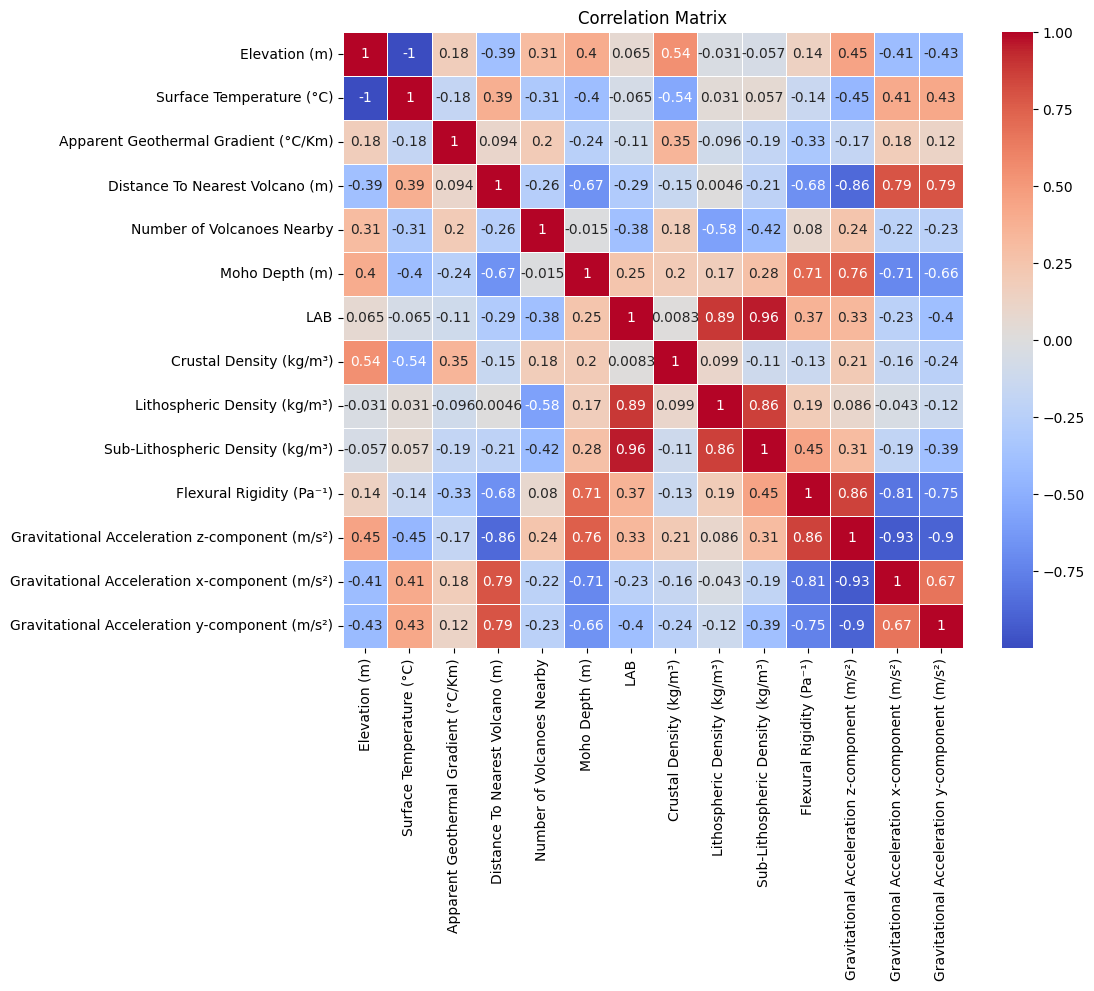

In [129]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select the desired columns
selected_columns = ['Elevation (m)', 'Surface Temperature (°C)',
       'Apparent Geothermal Gradient (°C/Km)',
       'Distance To Nearest Volcano (m)', 'Number of Volcanoes Nearby',
       'Moho Depth (m)', 'LAB', 'Crustal Density (kg/m³)',
       'Lithospheric Density (kg/m³)', 'Sub-Lithospheric Density (kg/m³)',
       'Flexural Rigidity (Pa⁻¹)',
       'Gravitational Acceleration z-component (m/s²)',
       'Gravitational Acceleration x-component (m/s²)',
       'Gravitational Acceleration y-component (m/s²)']

# Create a DataFrame with the selected columns
selected_data = cleaned_data[selected_columns]

# Calculate the correlation matrix
correlation_matrix = selected_data.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()


# Building Machine Learning Algorithm

## Data Splitting

In [130]:
# Define feature matrix (X) and target variables (y)
X = cleaned_data[['Latitude', 'Longitude','Elevation (m)', 'Surface Temperature (°C)',
       'Distance To Nearest Volcano (m)', 'Number of Volcanoes Nearby',
       'Moho Depth (m)', 'LAB', 'Crustal Density (kg/m³)',
       'Lithospheric Density (kg/m³)', 'Sub-Lithospheric Density (kg/m³)',
       'Gravitational Acceleration z-component (m/s²)',
       'Gravitational Acceleration x-component (m/s²)',
       'Gravitational Acceleration y-component (m/s²)']]

y = cleaned_data['Apparent Geothermal Gradient (°C/Km)']

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Save X_test with lat and lon for plotting later
X_test_with_lat_lon = X_test[['Latitude', 'Longitude']].copy()

# Save X with lat and lon for plotting later
X_lat_lon = X[['Latitude', 'Longitude']].copy()

# Remove lat and lon from X to predict on the whole dataset
X = X.drop(['Latitude', 'Longitude'], axis=1)

#Remove lat and lon from X_train and X_test
X_train = X_train.drop(['Latitude', 'Longitude'], axis=1)
X_test = X_test.drop(['Latitude', 'Longitude'], axis=1)


## Hyperparameter Tuning with Cross-Validation

Manually iterating over hyperparameter combinations and recording the progress using the tqdm library. 

In [131]:
from tqdm import tqdm
import itertools
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import ParameterGrid

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create the Random Forest model
rf_model = RandomForestRegressor(random_state=42)

# Perform grid search manually with a progress bar
param_grid_combinations = list(ParameterGrid(param_grid))
total_combinations = len(param_grid_combinations)

results = []

with tqdm(total=total_combinations) as pbar:
    for params in param_grid_combinations:
        rf_model.set_params(**params)
        rf_model.fit(X_train, y_train)
        y_pred = rf_model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        results.append((params, mse))
        pbar.update()

# Find the best hyperparameters
best_params, best_mse = min(results, key=lambda x: x[1])
print("Best Hyperparameters:", best_params)
print("Best Mean Squared Error:", best_mse)


  0%|          | 0/81 [00:00<?, ?it/s]

100%|██████████| 81/81 [02:22<00:00,  1.75s/it]

Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}
Best Mean Squared Error: 19.503933662214937


## Train Random Forest and evaluate model

In [132]:
best_rf_model = RandomForestRegressor(**best_params, random_state=42)
best_rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, min_samples_leaf=4, n_estimators=300,
                      random_state=42)

Evaluate the model's performance on the test data using appropriate regression metrics (e.g., MAE, RMSE, R-squared).

In [133]:
from sklearn.metrics import mean_absolute_error, r2_score

y_pred = best_rf_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

In [134]:
print(mae)
print(rmse)
print(r2)

2.94400852656299
4.416325810242598
0.40938981684553655


MAE represents the average absolute difference between the predicted and actual values. A MAE of 2.9440 suggests that, on average, model's predictions are approximately 2.9440 °C/Km away from the true values. Lower MAE is generally better, but the "goodness" of the value depends on the context and domain knowledge.

RMSE measures the square root of the average squared differences between predicted and actual values. It penalizes larger errors more than MAE. RMSE of 4.4163 indicates that, on average, model's predictions deviate by approximately 4.4163 °C/Km from the true values. Smaller RMSE values are preferred.

R-squared, or the coefficient of determination, represents the proportion of the variance in the dependent variable that's predictable from the independent variables. An R² of 0.409 suggests that the model explains approximately 41.00% of the variance in the target variable. A higher R² value is desirable.

# Visualization of results

## Feature Importance Plot

Visualize the importance of each feature in the Random Forest model. This will help to understand which features have the most significant impact on predicting the geothermal gradient.

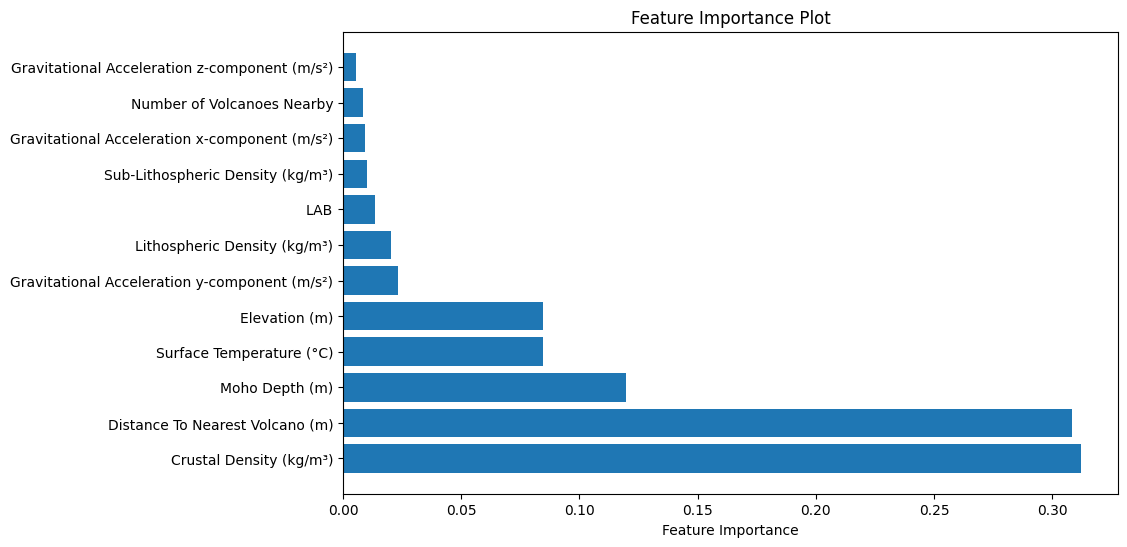

In [135]:
importances = best_rf_model.feature_importances_
feature_names = X.columns

# Sort importances in descending order
sorted_importances = sorted(zip(importances, feature_names), reverse=True)
top_features = [feature for importance, feature in sorted_importances]

plt.figure(figsize=(10, 6))
plt.barh(top_features, [importance for importance, _ in sorted_importances])
plt.xlabel('Feature Importance')
plt.title('Feature Importance Plot')
plt.show()

## Residual Plot

Create a residual plot to check if the model's predictions have a pattern. Most residuals must be near to zero

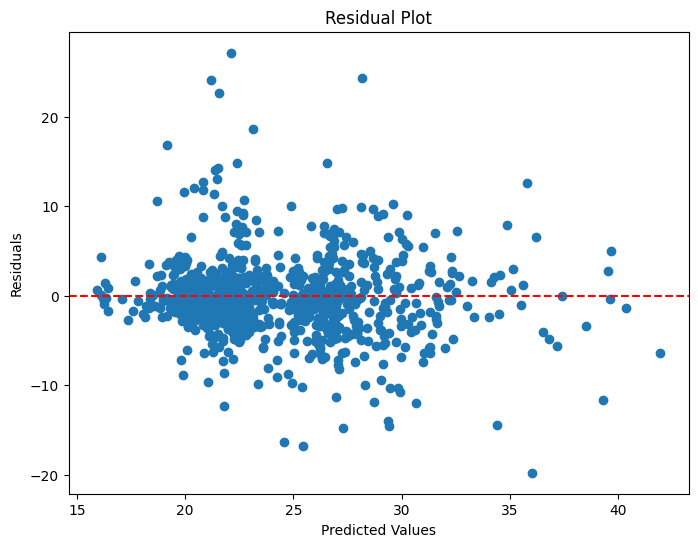

In [136]:
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residual Plot')
plt.show()

## Actual vs. Predicted Plot

Visualize how model's predictions compare to the actual values.

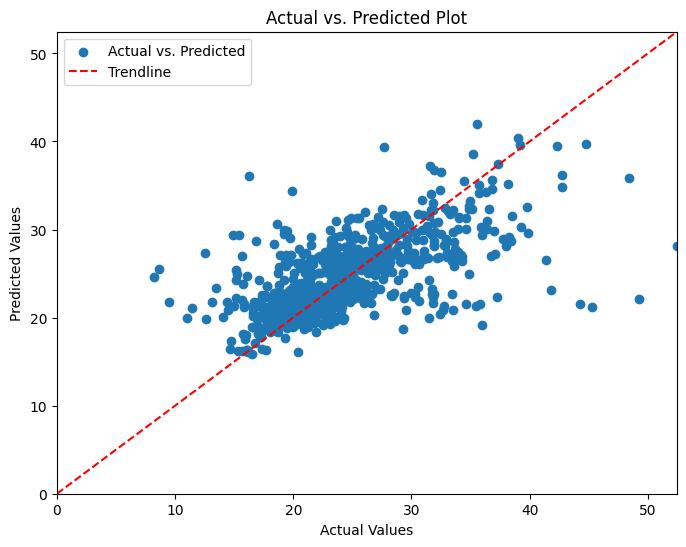

In [150]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, label='Actual vs. Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Plot')

# Set x and y axis limits to start at 0,0
max_value = max(max(y_test), max(y_pred))
plt.xlim(0, max_value)
plt.ylim(0, max_value)

# Calculate and plot the trendline
trendline_x = np.linspace(0, max_value, 100)
trendline_y = trendline_x  # Trendline starts from zero
plt.plot(trendline_x, trendline_y, color='red', linestyle='--', label='Trendline')

plt.legend()
plt.show()

## Partial Dependency Plots

Understand the relationship between a specific feature and the target while keeping other features constant.

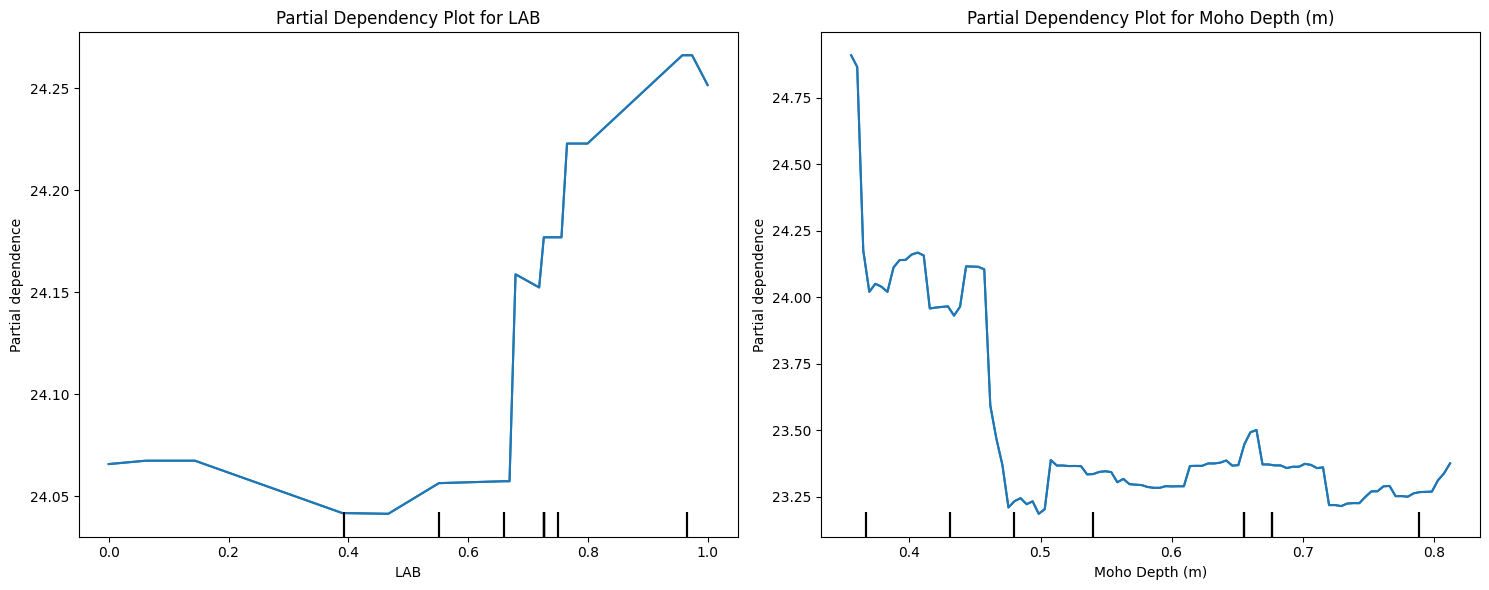

In [138]:
from sklearn.inspection import PartialDependenceDisplay

feature_indices = [X.columns.get_loc("LAB"), X.columns.get_loc("Moho Depth (m)")]

fig, axes = plt.subplots(1, 2, figsize=(15, 6))  # Create a single row with 2 subplots

for i, feature_index in enumerate(feature_indices):
    ax = axes[i]  # Select the appropriate subplot
    display = PartialDependenceDisplay.from_estimator(best_rf_model, X_train, features=[feature_index], ax=ax)
    display.plot(ax=display.axes_)
    ax.set_title(f'Partial Dependency Plot for {X.columns[feature_index]}')

plt.tight_layout()
plt.show()

## Geospatial visualization

### Actual data

In [2]:
actual_data = pd.read_csv('cleaned_data.csv')

### Predicted data

In [142]:
# Make predictions using the entire dataset (X)
y_pred_full = best_rf_model.predict(X)

# Update your existing DataFrame or create a new one to store the predictions
X_lat_lon['Predicted Geothermal Gradient (°C/Km)'] = y_pred_full

In [143]:
X_lat_lon.head()

,Latitude,Longitude,Predicted Geothermal Gradient (°C/Km)
0,4.213002,-74.893581,22.051429
1,4.216078,-74.888898,22.000779
2,4.214720,-74.891220,23.519765
3,5.830164,-74.321856,22.386587
4,5.092486,-74.585899,25.080824


In [144]:
X_lat_lon.to_csv('predicted_dataset.csv', index=False)

In [3]:
X_lat_lon = pd.read_csv('predicted_dataset.csv')

### Plot actual and predicted

/tmp/ipykernel_14248/645009238.py:42: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


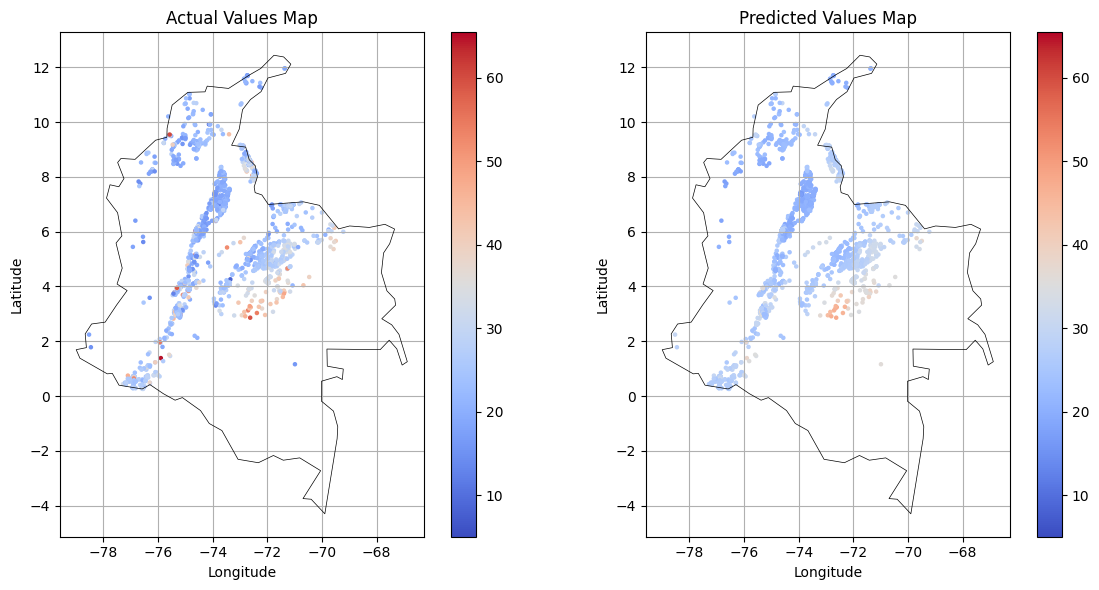

In [6]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load your GeoDataFrame for actual values
actual_gdf = gpd.GeoDataFrame(actual_data, geometry=gpd.points_from_xy(actual_data['Longitude'], actual_data['Latitude']))

# Load your GeoDataFrame for predicted values
predicted_gdf = gpd.GeoDataFrame(X_lat_lon, geometry=gpd.points_from_xy(X_lat_lon['Longitude'], X_lat_lon['Latitude']))

# Determine the color scale limits based on the min and max of both datasets
vmin = min(actual_data['Apparent Geothermal Gradient (°C/Km)'].min(), X_lat_lon['Predicted Geothermal Gradient (°C/Km)'].min())
vmax = max(actual_data['Apparent Geothermal Gradient (°C/Km)'].max(), X_lat_lon['Predicted Geothermal Gradient (°C/Km)'].max())

# Create subplots with two axes
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot actual values on the first subplot
actual_plot = actual_gdf.plot(column='Apparent Geothermal Gradient (°C/Km)', cmap='coolwarm', markersize=5, legend=True, ax=axes[0], vmin=vmin, vmax=vmax)
axes[0].set_title('Actual Values Map')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')

# Plot predicted values on the second subplot
predicted_plot = predicted_gdf.plot(column='Predicted Geothermal Gradient (°C/Km)', cmap='coolwarm', markersize=5, legend=True, ax=axes[1], vmin=vmin, vmax=vmax)
axes[1].set_title('Predicted Values Map')
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')

# Calculate grid positions based on min and max latitude and longitude
min_lon, max_lon = -78, -66
min_lat, max_lat = -4, 12
lon_grid = list(range(int(min_lon), int(max_lon) + 1, 2))
lat_grid = list(range(int(min_lat), int(max_lat) + 1, 2))

# Add gridlines for lat and lon to both subplots
for ax in axes:
    ax.set_xticks(lon_grid)
    ax.set_yticks(lat_grid)
    ax.grid()

# Load world country geometries
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Subset the world dataset to only include countries within your area of interest
world = world.cx[-74:-73, 4:5]

# Plot country borders within your area of interest for both subplots
for ax in axes:
    world.boundary.plot(ax=ax, linewidth=0.5, color='black')

# Show the combined plot with both subplots
plt.tight_layout()
plt.show()


### Difference between actual and predicted

/tmp/ipykernel_14248/4261831172.py:23: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


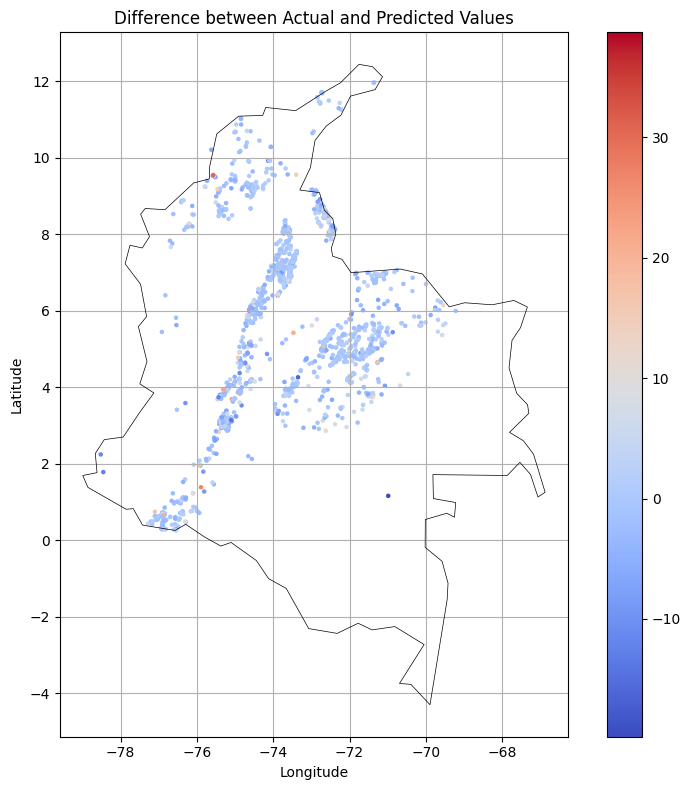

In [7]:
# Calculate the difference between actual and predicted values
actual_gdf['Apparent Geothermal Gradient (°C/Km)'] = actual_gdf['Apparent Geothermal Gradient (°C/Km)'] - predicted_gdf['Predicted Geothermal Gradient (°C/Km)']

# Create a plot for the difference values
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
difference_plot = actual_gdf.plot(column='Apparent Geothermal Gradient (°C/Km)', cmap='coolwarm', markersize=5, legend=True, ax=ax)
ax.set_title('Difference between Actual and Predicted Values')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Calculate grid positions based on min and max latitude and longitude
min_lon, max_lon = -78, -66
min_lat, max_lat = -4, 12
lon_grid = list(range(int(min_lon), int(max_lon) + 1, 2))
lat_grid = list(range(int(min_lat), int(max_lat) + 1, 2))

# Add gridlines for lat and lon
ax.set_xticks(lon_grid)
ax.set_yticks(lat_grid)
ax.grid()

# Load world country geometries
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Subset the world dataset to only include countries within your area of interest
world = world.cx[-74:-73, 4:5]

# Plot country borders within your area of interest
world.boundary.plot(ax=ax, linewidth=0.5, color='black')

# Show the plot
plt.tight_layout()
plt.show()
